# Analysis of Bumpless PI Controller

In [ ]:
# Set default parameters for publication quality plots
import matplotlib.pyplot as plt
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=3)

## Closed-Loop Dynamics

We start with the **velocity form** of the controller:

\begin{equation}
u_k = u_{k-1} + K_p (-y_k + y_{k-1}) + K_I \underbrace{(y_{SP} - y_f)\Delta t}_{e_k}
\end{equation}

Next, divide by $\Delta t$:

\begin{equation}
\frac{u_k - u_{k-1}}{\Delta t} = -K_p \frac{(y_k - y_{k-1})}{\Delta t} + K_I e_k
\end{equation}

Consider limit as $\Delta t \to 0$:

\begin{equation}
\dot{u} = -K_p \dot{y} + K_I e_k 
\end{equation}

Next, consider the two-state model for a single TCLab channel:

\begin{align}
C_p^H \frac{dT^*_{H,1}}{dt} &= -U_a T^*_{H,1} + U_b (T^*_{S,1} - T^*_{H,1}) + \alpha P_u \\
C_p^S \frac{dT^*_{S,1}}{dt} &= U_b (T^*_{H,1} - T^*_{S,1})
\end{align}

Next, substitute the control law:

\begin{equation}
\frac{du}{dt} = -K_p \dot{T}^*_{S,1} + K_I (T^*_{set} - T^*_{S,1})
\end{equation}

Finally, subsitute the second differential equation:

\begin{equation}
\frac{du}{dt} = -K_p \frac{U_b (T^*_{H,1} - T^*_{S,1})}{C_p^S} + K_I (T^*_{set} - T^*_{S,1})
\end{equation}

Now, we can write the model as a linear system:

\begin{equation}
\underbrace{\begin{bmatrix}
\dot{T}_{H,1} \\
\dot{T}_{S,1} \\
\dot{u}
\end{bmatrix}}_{\mathbf{\dot{x}}} =
\underbrace{\begin{bmatrix}
-\frac{U_a + U_b}{C_p^H} & \frac{U_b}{C_p^H} & \frac{\alpha P_i}{C_p^H} \\
\frac{U_b}{C_p^S} & -\frac{U_b}{C_p^S} & 0 \\
-\frac{K_p U_b}{C_p^S} & \frac{K_p U_b}{C_p^S} - K_I & 0
\end{bmatrix}}_{\mathbf{A}} 
\underbrace{\begin{bmatrix}
T_{H,1}^* \\
T_{S,1}^* \\
u
\end{bmatrix}}_\mathbf{x} +

\underbrace{\begin{bmatrix}
0 \\
0 \\
K_I
\end{bmatrix}}_\mathbf{B}
\underbrace{\begin{bmatrix} T^*_{set} \end{bmatrix}}_\mathbf{u}
\end{equation}

\begin{equation}
\underbrace{\begin{bmatrix} T^*_{S,1} \end{bmatrix}}_\mathbf{y} = 
\underbrace{\begin{bmatrix}
0 & 1 & 0
\end{bmatrix}}_\mathbf{C}
\underbrace{\begin{bmatrix}
T_{H,1} \\
T_{S,1} \\
u
\end{bmatrix}}_\mathbf{x} + 
\underbrace{\begin{bmatrix} 0 \end{bmatrix}}_{\mathbf{D}} 
\underbrace{\begin{bmatrix} T^*_{set} \end{bmatrix}}_\mathbf{u}


\end{equation}

## Simulation

In [ ]:
import numpy as np

# parameters
T_amb = 21 # deg C
alpha = 0.00016 # watts / (units P1 * percent U1)
P1 = 100 # P1 units
U1 = 50 # steady state value of u1 (percent)

# fitted parameters (see previous lab) for hardware
'''
Ua = 0.0261 # watts/deg C
Ub = 0.0222 # watts/deg C
CpH = 1.335 # joules/deg C
CpS = 1.328 # joules/deg C
'''

# fitted parameters (repeat Lab 3) for TCLab digital twin
Ua = 0.05 # watts/deg C
Ub = 0.05 # watts/deg C
CpH = 5.0 # joules/deg C
CpS = 1.0 # joules/deg C

In [ ]:
t = np.arange(0, 600, 1)
T_set = np.ones(t.shape)*5
T_set[100:] = 30

plt.step(t, T_set + T_amb, linestyle='-.', color='black', alpha=0.5)
plt.xlabel('Time [second]')
plt.ylabel('Setpoint [° C]')
plt.show()

### Continuous Simulation

### Discrete Simulation

In [ ]:
import pandas as pd
from scipy.signal import cont2discrete


def tclab_simulate_bumpless_PI(Kp = 1.0, Ki = 0.05, verbose=False, plot=True):
    ''' Simulate the TCLab system with PI control
    Arguments:
        Kp: the proportional control gain
        Ki: the integral control gain
        verbose: print matrices, default is False
        plot: create plots, default is True

    Returns:
        data: DataFrame with columns for Time, T1, T2, Q1, Q2
    '''

    n = len(t)

    assert len(T_set) == n, 'Setpoint array must have the same length as time array'

    # Original open loop state space model
    A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
    B = np.array([[alpha*P1/CpH], [0]])
    C = np.array([[0, 1]])
    D = np.array([[0]])

    Ad, Bd, Cd, Dd, dt = cont2discrete((A, B, C, D), dt=1, method='zoh')

    # Initialize state matrix
    X = np.zeros((n, 2))

    # Initialize input matrix
    U = np.zeros((n, 1))

    prev_error = 0


    # Loop over time steps
    for i in range(n):
    

        # Current state
        x = X[i, :]

        # Unpack into individual states
        T1H, T1S = x

        error = T_set[i] - T1S

        if i > 0:
            dt = t[i] - t[i-1]
            U[i,0] = U[i-1,0] + Kp*(error-prev_error) +  dt*Ki*(error)

        # Limit the power levels
        U[i, 0] = max(0, min(100, U[i, 0]))

        # Update state
        if i < n-1:
            # Do not update the state for the last time step
            # We want to update U and SP for plotting
            X[i + 1, :] = Ad @ x + Bd @ U[i, :]

        prev_error = error


    # Shift states from deviation variables to absolute values
    X += T_amb

    # Create DataFrame
    data = pd.DataFrame(X, columns=['T1H', 'T1S'])
    data['Time'] = t
    data['Q1'] = U[:, 0]
    data['SP1'] = T_set + T_amb

    if plot:
        plt.title('Channel 1, Simulated P Control with Kp={}, Ki={}'.format(Kp,Ki))
        plt.step(data['Time'], data['T1H'], label='T1H', linestyle='--')
        plt.step(data['Time'], data['T1S'], label='T1S', linestyle='-')
        plt.step(data['Time'], data['SP1'], label='SP1', linestyle='-.', color='black', alpha=0.5)
        plt.ylabel('Temperature (C)')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.grid()
        plt.show()
        

        plt.title('Heaters, Simulated P Control with Kp={}, Ki={}'.format(Kp,Ki))
        plt.step(data['Time'], data['Q1'], label='Q1')
        plt.xlabel('Time (s)')
        plt.ylabel('Power Level (%)')
        plt.legend()
        plt.grid()
        plt.show()

    return data

tclab_simulate_bumpless_PI(Kp=10.0, Ki=0.2)

## Stability Analysis

In [9]:
# Eigendecomposition analysis
from scipy.linalg import eig
import numpy as np

def calc_eig(Kp, Ki, verbose=True):
    """Calculates the eigenvalues and eigenvectors of the A_PI matrix.

    Args:
        Kp: Proportional gain.
        Ki: Integral gain.
        verbose: If True, prints the eigenvalues and eigenvectors.

    Returns:
        A numpy array containing the eigenvalues.
    """

    A_PI = np.array([[-(Ua + Ub)/CpH, Ub/CpH, alpha*P1/CpH], 
                [Ub/CpS, -Ub/CpS, 0],
                [-Kp*Ub/CpS, Kp*Ub/CpS - Ki, 0]])
    
    w, vl = eig(A_PI)

    if verbose:
        for i in range(len(w)):
            print("Eigenvalue",i,"=",w[i])
            print("Eigenvector",i,"=",vl[:,i],"\n")

    return w

calc_eig(1.5, 0.01)

Eigenvalue 0 = (-0.057644127570114174+0j)
Eigenvector 0 = [ 0.09164288 -0.59943323  0.79516124] 

Eigenvalue 1 = (-0.009404448645463076+0j)
Eigenvector 1 = [-0.5969477  -0.73523783  0.32105883] 

Eigenvalue 2 = (-0.0029514237844228135+0j)
Eigenvector 2 = [0.40304171 0.42832509 0.80876139] 



array([-0.05764413+0.j, -0.00940445+0.j, -0.00295142+0.j])

<Figure size 640x480 with 0 Axes>

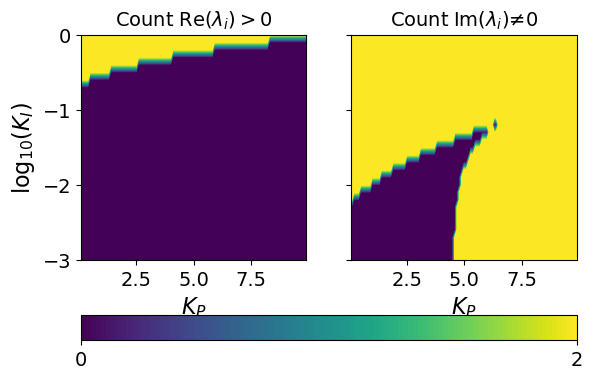

In [7]:
Kp_range = np.arange(0.1,10,0.1)
Ki_range = np.arange(-3,0.1,0.1)
xv, yv = np.meshgrid(Kp_range, Ki_range)

# store eigenvalues in 3D array
s3 = (len(Ki_range),len(Kp_range),3)
s2 = (len(Ki_range),len(Kp_range))
ev = np.zeros(s3, dtype=complex)
positive_real_eig = np.zeros(s2)
nonzero_imag_eig = np.zeros(s2)

small_number = 1E-9

for i in range(len(Ki_range)):
    for j in range(len(Kp_range)):
        ev[i,j,:] = calc_eig(xv[i,j], np.power(10,yv[i,j]), verbose=False)[:]
        positive_real_eig[i,j] = sum(np.real(ev[i,j,:]) >= -small_number)
        nonzero_imag_eig[i,j] = sum(np.abs(np.imag(ev[i,j,:])) >= small_number)

plt.figure()
fig, axs = plt.subplots(1,2, sharey=True)

axs[0].set_box_aspect(1)
cs = axs[0].contourf(xv,yv,positive_real_eig, levels=100)
axs[0].set_xlabel('$K_P$')
axs[0].set_ylabel('log$_{10}$($K_I$)')
axs[0].set_title('Count Re($\lambda_i$)$>0$')

axs[1].set_box_aspect(1)
cs = axs[1].contourf(xv,yv,nonzero_imag_eig, levels=100)

axs[1].set_xlabel('$K_P$')
#axs[1].set_ylabel('log$_{10}$($K_i$)')
axs[1].set_title('Count Im($\lambda_i$)$≠0$')


cbar = fig.colorbar(cs, ticks=[0, 2], orientation='horizontal', ax=axs[:])

#plt.tight_layout()
plt.show()